In [1]:
%load_ext autoreload
%autoreload 2

import sys
import torch
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from scipy.stats import spearmanr

sys.path.append('..')
sys.path.append('pLMtrainer')
from pLMtrainer import utils

#torch.set_float32_matmul_precision('medium')

parquet_path = "../data/frustration/v4_frustration.parquet.gzip"

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pq.read_table(parquet_path).to_pandas()
df.head(2)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id,frst_class_3
0,AF-A0A009EQP3-F1-model_v4_TED02,MKESLRLRLDQLSDRHEELTALLADVEVISDNKRFRQLSREHNDLT...,"[Y, L, E, I, R, A, G, T, G, G, D, E, A, A, I, ...","[111, 112, 113, 114, 115, 116, 117, 118, 119, ...","[0.235, 1.632, -0.844, 1.365, 0.282, -0.384, 0...","[9, 6, 11, 6, 9, 10, 9, 9, 9, 11, 12, 13, 9, 8...",train,3.30.70,"[1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, ..."
1,AF-A0A009F754-F1-model_v4_TED02,MANPAQLVRHKLLNTFFSRHSVWFACITIAVIFTIFHIGYEPRYIY...,"[R, I, L, I, G, N, E, Q, C, T, Q, P, Y, S, A, ...","[164, 165, 166, 167, 168, 169, 170, 171, 172, ...","[-1.068, 1.469, -0.317, 1.098, -0.663, -0.771,...","[12, 6, 10, 7, 11, 11, 7, 10, 3, 9, 13, 11, 9,...",train,3.20.20,"[0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 2, ..."


In [3]:
train_df = df[df["set"] == "train"]
val_df = df[df["set"] == "val"]
test_df = df[df["set"] == "test"]

In [4]:
residues = np.concatenate(train_df["res_seq"].to_numpy())
residues

array(['Y', 'L', 'E', ..., 'D', 'D', 'E'],
      shape=(170311084,), dtype=object)

In [5]:
reg_vals = np.concatenate(train_df["frst_idx"].to_numpy())
reg_vals

array([ 0.235,  1.632, -0.844, ..., -0.876, -0.435, -1.164],
      shape=(170311084,))

In [6]:
cls_vals = np.concatenate(train_df["frst_class_3"].to_numpy())
cls_vals

array([1, 2, 1, ..., 1, 1, 0], shape=(170311084,))

In [7]:
res_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
len(res_list)

20

In [8]:
reg_dict = {}
cls_dict = {}
for res in res_list:
    mask = np.where(residues == res)
    reg_dict[res] = {
        "mean": reg_vals[mask].mean(),
        "std": reg_vals[mask].std()
    }
    bincount = np.bincount(cls_vals[mask])
    cls_dict[res] = {
        "majority_class": bincount.argmax(),
        "bincount": bincount,
        "probabilities": bincount / bincount.sum()
    }

In [9]:
CNN_test = np.load("../data/it3_lora/loraQK_test_preds.npz")
CNN_test.files

['full_seqs',
 'masks',
 'regr_preds',
 'cls_preds',
 'regr_targets',
 'cls_targets',
 'masked_regr_preds',
 'masked_cls_preds',
 'masked_regr_targets',
 'masked_cls_targets']

In [10]:
padded_seqs = []
for seq in CNN_test["full_seqs"]:
    if len(seq) < 512:
        # Pad the sequence
        padding = "X" * (512 - len(seq))
        padded_seqs.append(seq + padding)
    else:
        # Truncate the sequence
        padded_seqs.append(seq[:512])
padded_seqs = np.array(padded_seqs)
padded_seqs.shape

(56892,)

In [11]:
seq_array = np.array([list(seq) for seq in padded_seqs])
seq_array.shape

(56892, 512)

In [12]:
masked_residues = seq_array[CNN_test["masks"]]
masked_residues.shape

(9575120,)

In [13]:
masked_residues

array(['A', 'K', 'A', ..., 'E', 'Y', 'R'], shape=(9575120,), dtype='<U1')

In [14]:
mean_regr_preds = np.array([reg_dict[res]["mean"] for res in masked_residues])

In [15]:
majority_cls_preds = np.array([cls_dict[res]["majority_class"] for res in masked_residues])

In [16]:
mean_regr_preds.shape, majority_cls_preds.shape

((9575120,), (9575120,))

In [17]:
MAJ_report = classification_report(CNN_test["masked_cls_targets"], 
                                   majority_cls_preds, 
                                   labels=range(3), digits=4, zero_division=0)

In [18]:
np.bincount(CNN_test["masked_cls_targets"]), np.bincount(majority_cls_preds)

(array([1079124, 4868864, 3627132]), array([      0, 6600767, 2974353]))

In [19]:
print(MAJ_report)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000   1079124
           1     0.6893    0.9345    0.7934   4868864
           2     0.8840    0.7249    0.7966   3627132

    accuracy                         0.7498   9575120
   macro avg     0.5244    0.5531    0.5300   9575120
weighted avg     0.6854    0.7498    0.7052   9575120



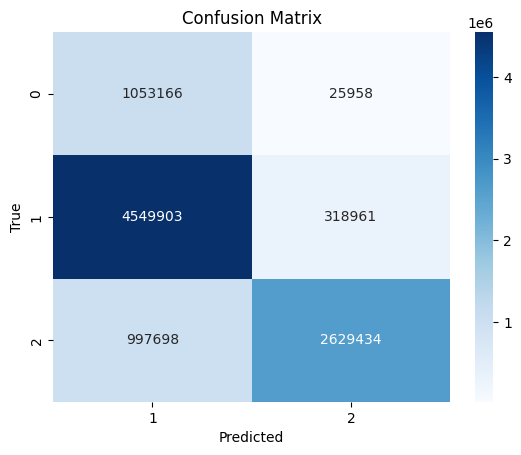

In [20]:
# make a confusion matrix
confusion_matrix = pd.crosstab(CNN_test["masked_cls_targets"], majority_cls_preds, rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [21]:
spearmanr(CNN_test["masked_regr_targets"], mean_regr_preds)

SignificanceResult(statistic=np.float64(0.6813774528091201), pvalue=np.float64(0.0))

In [22]:
mean_absolute_error(CNN_test["masked_regr_targets"], mean_regr_preds)

0.4945305120775111

In [23]:
r2_score(CNN_test["masked_regr_targets"], mean_regr_preds)

0.5149288076445904

Text(0, 0.5, 'Mean residue frustration')

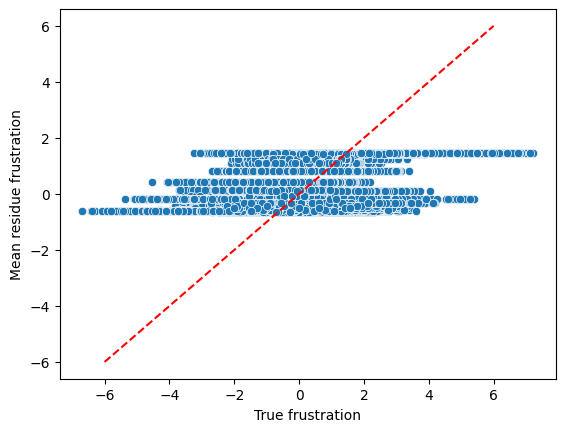

In [24]:
sns.scatterplot(x=CNN_test["masked_regr_targets"], y=mean_regr_preds, color="C0")
plt.plot([-6, 6], [-6, 6], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("Mean residue frustration")

Text(39.222222222222214, 0.5, 'Mean residue frustration')

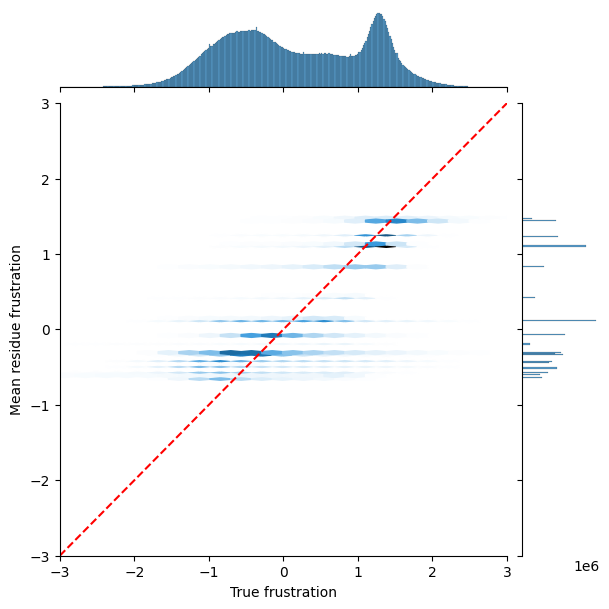

In [25]:
sns.jointplot(x=CNN_test["masked_regr_targets"], y=mean_regr_preds, kind="hex", xlim=(-3,3), ylim=(-3,3), color="C0")
plt.plot([-3, 3], [-3, 3], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("Mean residue frustration")

In [26]:
bootstrap_regr_mean = utils.bootstrapping_regression(CNN_test["masked_regr_targets"], mean_regr_preds, n_bootstrap=100)
bootstrap_regr_mean["method"] = ["Mean"] * 100

In [29]:
bootstrap_regr_df = pd.read_csv("bootstrap_regr_df.csv")
bootstrap_regr_df = pd.concat([bootstrap_regr_df, pd.DataFrame(bootstrap_regr_mean)], ignore_index=True)
bootstrap_regr_df.to_csv("bootstrap_regr_df.csv", index=False)
bootstrap_regr_df

,spearman_r,mae,r2,method
0,0.822030,0.398971,0.675051,CNN
1,0.822145,0.398782,0.675385,CNN
2,0.822131,0.399012,0.675180,CNN
3,0.822083,0.399142,0.675158,CNN
4,0.822109,0.399034,0.675241,CNN
...,...,...,...,...
295,0.681355,0.494738,0.514808,Mean
296,0.681321,0.494552,0.515019,Mean
297,0.681489,0.494258,0.515305,Mean
298,0.681383,0.494391,0.515046,Mean


In [ ]:
pd.pivot_table(bootstrap_regr_df, )

ValueError: No group keys passed!

<Axes: ylabel='spearman_r'>

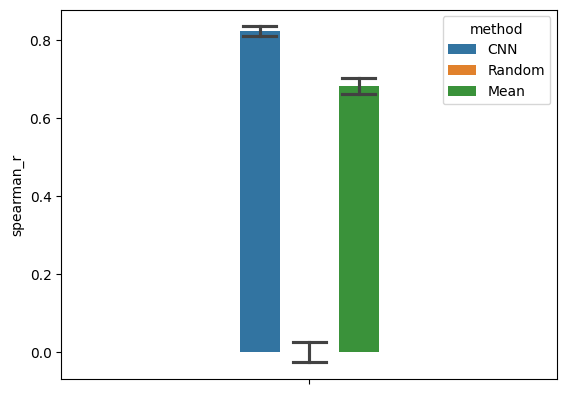

In [33]:
sns.barplot(data=bootstrap_regr_df, hue="method", y="spearman_r", errorbar=("sd", 95), capsize=.2, width=0.3, palette="tab10", gap=0.2)

In [34]:
res_df = pd.DataFrame({"regr_pred": CNN_test["masked_regr_preds"],
                       "true_reg": CNN_test["masked_regr_targets"],
                       "cls_pred": CNN_test["masked_cls_preds"],
                       "cls_target": CNN_test["masked_cls_targets"],
                       "residue": masked_residues,
                       "mean_residue_frst": mean_regr_preds,
                       "majority_cls_preds": majority_cls_preds
                       })
res_df

,regr_pred,true_reg,cls_pred,cls_target,residue,mean_residue_frst,majority_cls_preds
0,0.031655,-0.879,1,1,A,0.124539,1
1,1.328626,1.250,2,2,K,-0.428332,1
2,0.640119,-0.937,2,1,A,0.124539,1
3,0.078500,1.204,1,2,E,-0.508774,1
4,0.315636,0.978,1,2,E,-0.508774,1
...,...,...,...,...,...,...,...
9575115,1.230610,1.149,2,2,L,1.110944,2
9575116,-0.891374,-1.287,1,0,E,-0.508774,1
9575117,-0.579436,-0.010,1,1,E,-0.508774,1
9575118,-0.477728,-1.478,1,0,Y,-0.593447,1


In [35]:
res_df_sub = res_df.sample(1000000, random_state=42)
res_df_sub

,regr_pred,true_reg,cls_pred,cls_target,residue,mean_residue_frst,majority_cls_preds
3387255,-0.247734,0.104,1,1,W,-0.198030,1
4535045,-0.680318,-1.219,1,0,N,-0.434767,1
6532567,-0.041693,1.173,1,2,Q,-0.648980,1
2193737,0.165828,-0.441,1,1,K,-0.428332,1
5278402,1.236696,1.326,2,2,V,1.237151,2
...,...,...,...,...,...,...,...
6851893,-0.911659,-1.144,1,0,K,-0.428332,1
9177927,-0.592627,-0.660,1,1,E,-0.508774,1
3907879,-0.635298,-1.408,1,0,Q,-0.648980,1
1066758,-0.443592,-0.815,1,1,G,-0.341261,1


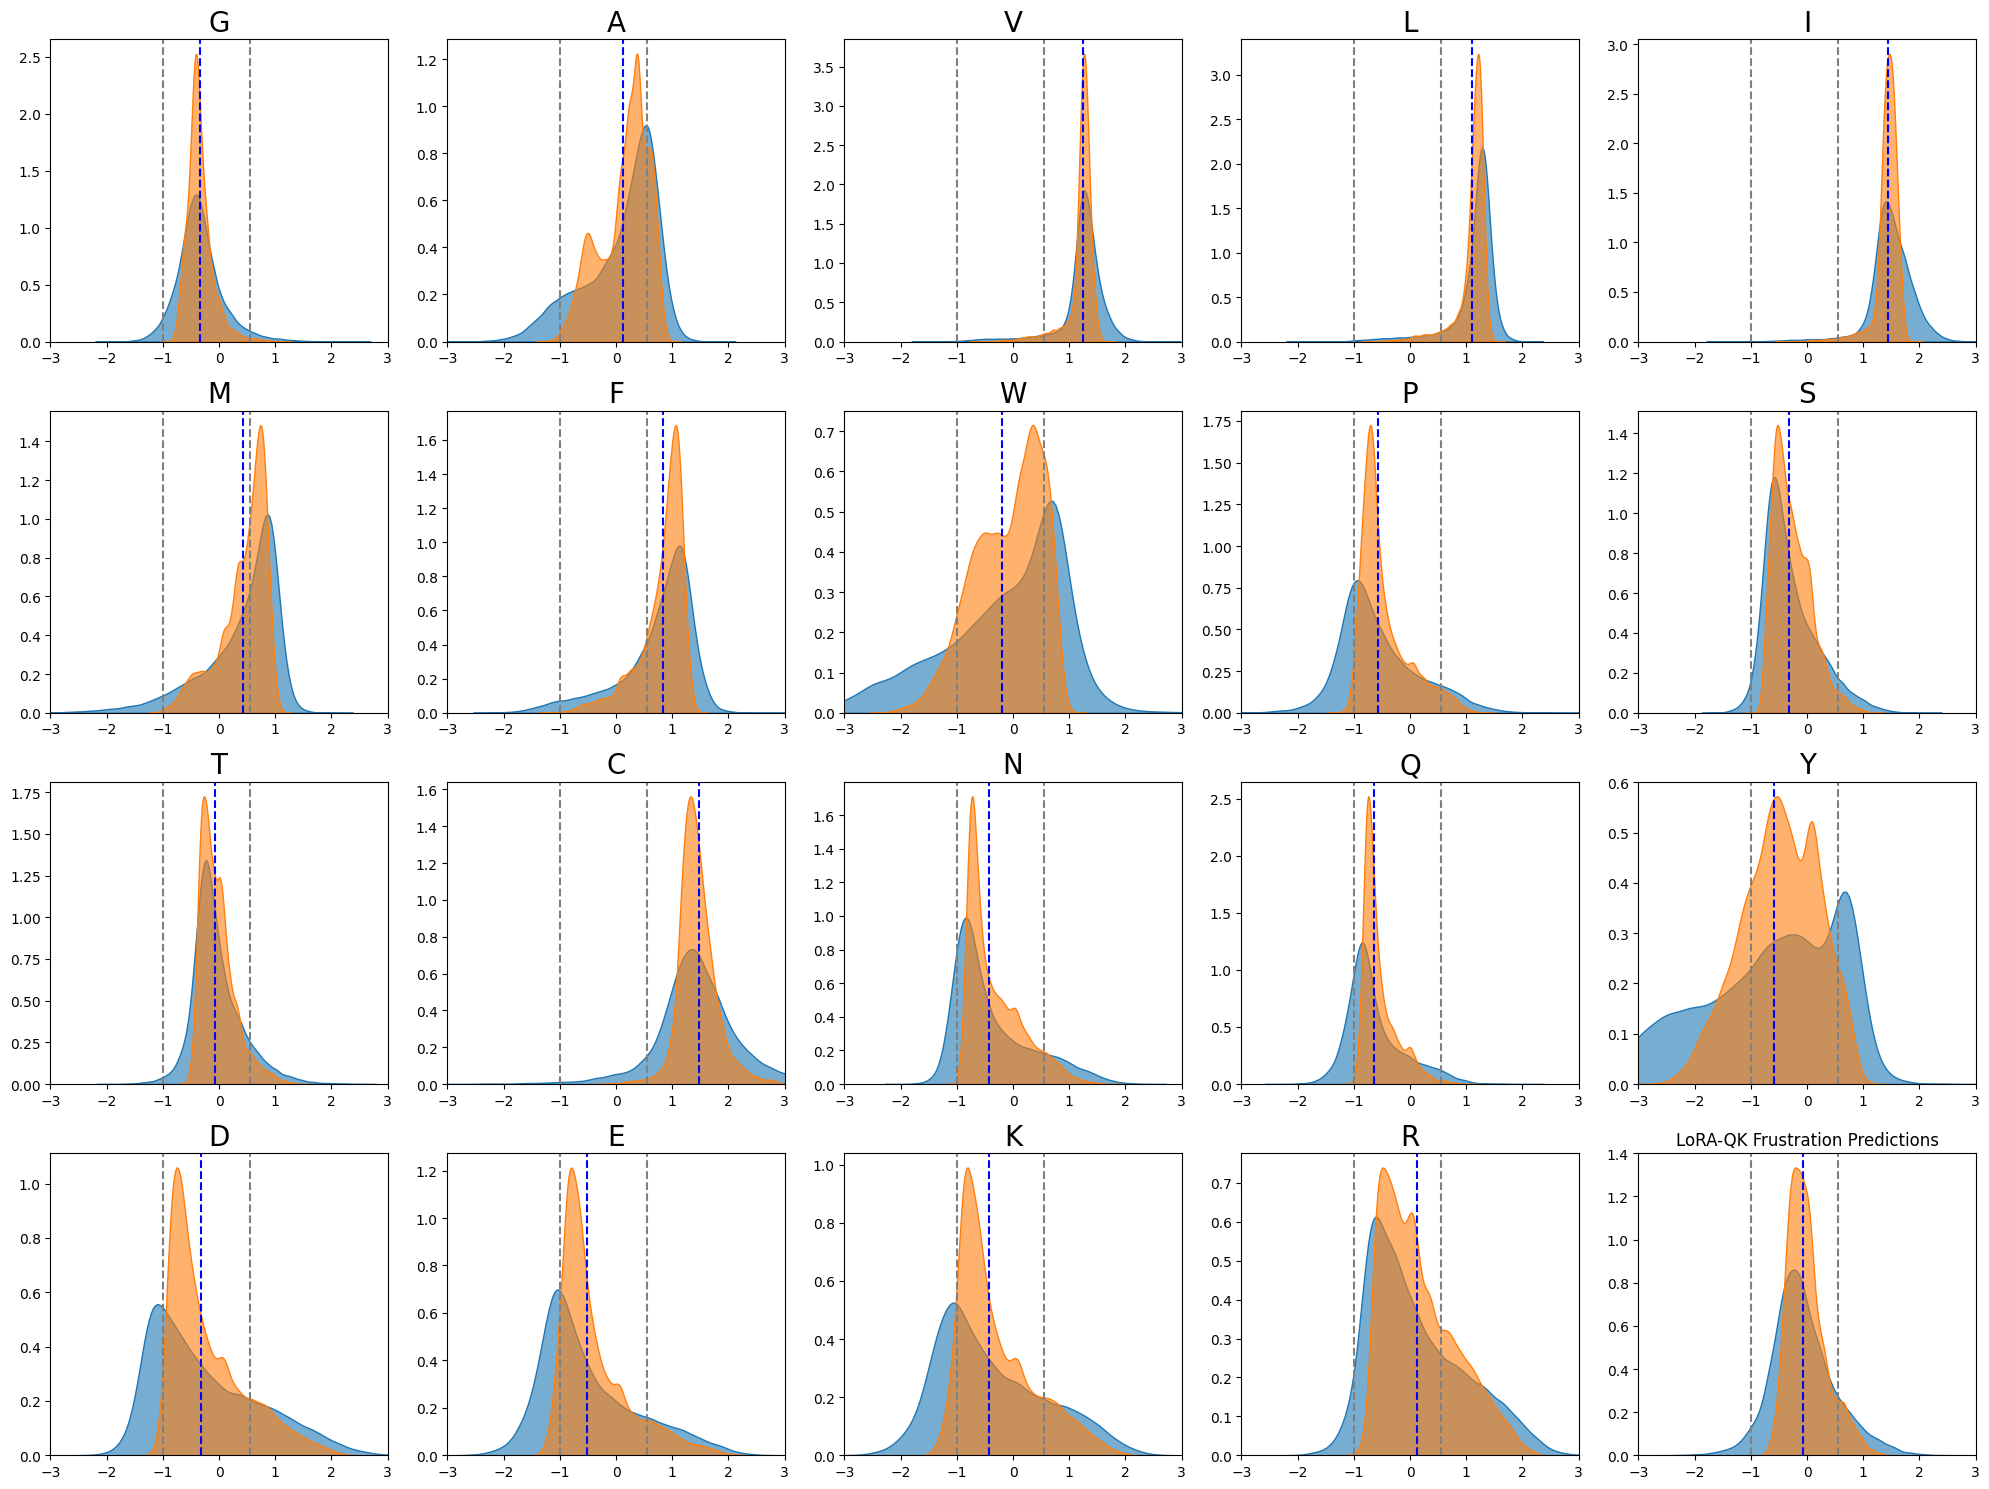

In [37]:
#make a fig with 20 subplots 5rows and 4 columns showing jointplots for each residue type
fig, axes = plt.subplots(4, 5, figsize=(20, 15))
residues = res_df_sub["residue"].unique()
residues = ["G", "A", "V", "L", "I", "M", "F", "W", "P", "S", "T", "C", "N", "Q", "Y", "D", "E", "K", "R", "H"]
plt_legend = False
for i, residue in enumerate(residues):
    ax = axes[i // 5, i % 5]
    subset = res_df_sub[res_df_sub["residue"] == residue]
    res = subset["residue"].unique()[0]
    sns.kdeplot(data=subset, x="true_reg", ax=ax, color="C0", alpha=0.6, fill=True, label="True frustration")
    sns.kdeplot(data=subset, x="regr_pred", ax=ax, color="C1", alpha=0.6, fill=True, label="Predicted frustration")
    ax.axvline(reg_dict[res]["mean"], color="blue", linestyle="--", label="Mean true frustration")
    ax.axvline(-1, color="gray", linestyle="--", label="Thresholds")
    ax.axvline(0.55, color="gray", linestyle="--")
    ax.set_xlim(-3, 3)
    ax.set_title(f'{residue}', fontsize=20)

    #ax.set_xlabel("Frustration")
    #ax.set_ylabel("Density")
    ax.set_xlabel("")
    ax.set_ylabel("")
    if plt_legend:
        plt_legend = False
        ax.legend(fontsize=20)
plt.title("LoRA-QK Frustration Predictions")
plt.tight_layout()
plt.show()

In [65]:
subset["residue"].unique()[0]

'H'

In [3]:
sys.path.append('..')
from pLMtrainer.dataloader import FrustrationDataModule
from pLMtrainer.models import FrustrationCNN

exp_name = "it2_debug"
parquet_path = "pLMtrainer/data/frustration/v4_frustration.parquet.gzip"
max_seq_length = 512
batch_size = 64
num_workers = 10
cath_sampling_n = 100  # None for no sampling

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [116]:
data_module = FrustrationDataModule(df=None,
                                    parquet_path=parquet_path, 
                                    batch_size=batch_size, 
                                    max_seq_length=max_seq_length, 
                                    num_workers=num_workers, 
                                    persistent_workers=True,
                                    sample_size=None,
                                    cath_sampling_n=cath_sampling_n)

model = FrustrationCNN.load_from_checkpoint(checkpoint_path=f"../data/it2/train_best.ckpt",
                                            input_dim=1024, 
                                            hidden_dims=[64, 10], 
                                            output_dim=4, # 3 classes + 1 for regression 
                                            dropout=0.15,
                                            max_seq_length=max_seq_length,
                                            precision="half", 
                                            pLM_model="../data/protT5",
                                            prefix_prostT5="<AA2fold>",
                                            no_label_token=-100,)

Using half precision


In [117]:
trained = model.encoder.state_dict()["encoder.block.1.layer.0.SelfAttention.q.weight"]

In [4]:
data_module = FrustrationDataModule(df=None,
                                    parquet_path=parquet_path, 
                                    batch_size=batch_size, 
                                    max_seq_length=max_seq_length, 
                                    num_workers=num_workers, 
                                    persistent_workers=True,
                                    sample_size=None,
                                    cath_sampling_n=cath_sampling_n)

model = FrustrationCNN(input_dim=1024, 
                       hidden_dims=[64, 10], 
                       output_dim=4, # 3 classes + 1 for regression 
                       dropout=0.15,
                       max_seq_length=max_seq_length,
                       precision="half", 
                       pLM_model="../data/protT5",
                       prefix_prostT5="<AA2fold>",
                       no_label_token=-100,)

Using half precision


In [5]:
fresh = model.encoder.state_dict()["encoder.block.1.layer.0.SelfAttention.q.weight"]

In [6]:
fresh

tensor([[-0.0060,  0.0209, -0.0243,  ...,  0.0023,  0.0087,  0.0052],
        [ 0.0060,  0.0203, -0.0149,  ...,  0.0077,  0.0052,  0.0031],
        [ 0.0087, -0.0002,  0.0015,  ...,  0.0026,  0.0089, -0.0002],
        ...,
        [-0.0021,  0.0024, -0.0078,  ..., -0.0067,  0.0193,  0.0054],
        [-0.0060,  0.0306, -0.0054,  ...,  0.0059, -0.0044, -0.0133],
        [ 0.0127, -0.0177, -0.0060,  ...,  0.0016, -0.0042, -0.0140]],
       dtype=torch.float16)

In [120]:
(trained - fresh).sum()

tensor(0., dtype=torch.float16)